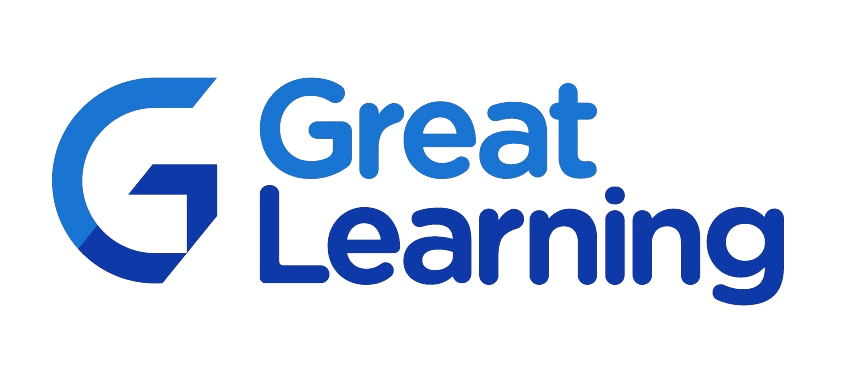

# **Voicebot with Neural Intent Identification**

------------------------------------------------------------------------------------

## **Problem Statement and Objective**
-----------------------------------------------------------------------------------------
In this project, we are going to build our own Conversational AI Framework where we will target only the Natural Language Understanding aspect of these conversations. We will be aiming to identify intents from the user's message and give a suitable reply based on that message in a one-to-one mapping. Each intent will have a pre-defined set of responses, which will be sent as outputs of the bot. The objective is to build a Neural Network model that identifies intents with high accuracies.

You can assume that this framework is being built for a Pizza Ordering FAQ Chatbot present on the business website of a Pizza restaurant. The questions and answers catered to by this bot will be in the nature of such a business.



## **0. Dataset and Intents (25 marks)**


The dataset file is named 'intents_pizza.json'. However, this is not a dataset of conversations, but rather a file that contains intents, patterns and responses. Although the file has been pre-filled with a few intents and questions that would be typical of such a chatbot, you are required to further populate the json file with further intents and questions that you would like to include in your chatbot.

## **1. Importing the Necessary Libraries**

In [1]:
!pip install gTTS
!pip install transformers
from abc import ABCMeta, abstractmethod
import matplotlib.pyplot as plt

import random
import json
import pickle
import numpy as np
import os

# Setting the environment variable to suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Importing NLTK library and WordNet lemmatizer
import nltk
from nltk.stem import WordNetLemmatizer


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Embedding, Layer, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D, LSTM
from tensorflow.keras.optimizers import SGD, Adam
# Importing function to load a saved Keras model
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from nltk.corpus import stopwords
#Load best model
from keras.models import load_model
#For bonus transfer learning
from transformers import TFBertModel, BertTokenizer

# Downloading necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

True

## **2. Initializing the Lemmatizer**

In [2]:
lemmatizer = WordNetLemmatizer()
intents = json.loads(open('intents_pizza.json').read())

The second line of code loads a JSON file called intents_pizza.json and parses its contents into a Python object using the json module.

The intents_pizza.json file contains a collection of intents and their associated responses, which will be used to build the chatbot.

## **3. Creating the Training Data from the Intents Dataset**

In [3]:
words = []
classes = []
documents = []
ignore_letters = ['!', '?', ',', '.'] # The ignore letters is a list of characters that won't be tokenized. You can populate this further with characters you want to ignore.

In [4]:
patterns=[]
for intent in intents['intents']:             # Iterate over each intent in the intents object
    for pattern in intent['patterns']:        # Iterate over each pattern (i.e., example sentence) associated with the current intent
       patterns.append(pattern)
       word_list = nltk.word_tokenize(pattern)
       words.extend(word_list)                # The array words acts as the Vocabulary
       documents.append((word_list, intent['tag'])) # The array documents contain the training data in the ['text', 'intent'] format
       if intent['tag'] not in classes:
          classes.append(intent['tag'])      # The array classes contain all the output classes.

print(documents)

[(['Hi'], 'greeting'), (['How', 'are', 'you'], 'greeting'), (['Is', 'anyone', 'there', '?'], 'greeting'), (['Hello'], 'greeting'), (['Good', 'day'], 'greeting'), (['Whats', 'up'], 'greeting'), (['Hey'], 'greeting'), (['greetings'], 'greeting'), (['Hey', 'there'], 'greeting'), (['Howdy'], 'greeting'), (['Hiya'], 'greeting'), (['Hola'], 'greeting'), (['Yo'], 'greeting'), (['Hi', 'there'], 'greeting'), (['Good', 'evening'], 'greeting'), (['Hello', 'there'], 'greeting'), (['Good', 'to', 'see', 'you'], 'greeting'), (['Nice', 'to', 'meet', 'you'], 'greeting'), (['Pleased', 'to', 'meet', 'you'], 'greeting'), (['Good', 'afternoon'], 'greeting'), (['Good', 'morning'], 'greeting'), (['What', "'s", 'going', 'on', '?'], 'greeting'), (['What', "'s", 'new', '?'], 'greeting'), (['How', "'s", 'it', 'going', '?'], 'greeting'), (['How', 'are', 'things', '?'], 'greeting'), (['How', "'s", 'life', '?'], 'greeting'), (['How', "'s", 'your', 'day', '?'], 'greeting'), (['How', "'s", 'your', 'day', 'going', '?'

In [5]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
words = sorted(list(set(words)))

In [6]:
classes = sorted(list(set(classes)))
print(classes)

['Change_request', 'Menu', 'Refund', 'Status', 'Thanks', 'delivery', 'goodbye', 'greeting', 'hours', 'price', 'vegan']


In [7]:
import copy
training = []
output_empty = [0] * len(classes)

for document in documents:
   bag = []
   word_patterns = document[0]
   word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
   for word in words:
     bag.append(1) if word in word_patterns else bag.append(0)

   output_row = list(output_empty)
   output_row[classes.index(document[1])] = 1
   training.append([bag, output_row])
unshuffled_training=copy.deepcopy(np.array(training))
unshuffled_y=np.array(list(unshuffled_training[:, 1]))

<ipython-input-7-9d31da09baf1>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unshuffled_training=copy.deepcopy(np.array(training))


In [8]:
random.shuffle(training)
training = np.array(training)
train_x = list(training[:, 0])
train_y = list(training[:, 1])


print(np.array(train_x).shape)

(834, 593)


<ipython-input-8-ae288962ba42>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


## **4. Model Building**

In this part of the project, you will need to build the model to take in the user text as input and classify it as one of the existing intents present in the intents_pizza.json file. Since this is a classification task, the output layer should have as many neurons as **len(train_y[0])**.

You may choose any type of neural layers or any composite units while building the model. You can also choose to use a pre-trained model which you need to fine-tune based on the current classification data present in the intents_pizza.json.

### **4.1 Build and compile a simple model with fewer parameters and check the training accuracy (10 marks)**

In [9]:
neurons=64
#start simple NN model
model = Sequential()
x_len=len(train_x[0])
y_len=len(train_y[0])
train_x=np.array(train_x)
train_y=np.array(train_y)
# Inout
model.add(Dense(128, input_dim=x_len, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(neurons, activation='relu'))
model.add(Dropout(0.5))
# Output
model.add(Dense(y_len, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               76032     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 11)                715       
                                                                 
Total params: 85,003
Trainable params: 85,003
Non-trainable params: 0
_________________________________________________________________


### **4.2 Train your model (15 marks)**

In [10]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 5, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)
history = model.fit(train_x,train_y,
                    epochs=100,
                    validation_split=0.2,
                    batch_size=5,
                    callbacks=[earlystopping, checkpoint, learning_rate_reduction])

Epoch 1/100
130/134 [============================>.] - ETA: 0s - loss: 2.3006 - accuracy: 0.2108
Epoch 1: val_loss improved from inf to 2.09926, saving model to model.h5
134/134 [==============================] - 2s 6ms/step - loss: 2.2949 - accuracy: 0.2159 - val_loss: 2.0993 - val_accuracy: 0.4910 - lr: 0.0010
Epoch 2/100
125/134 [==========================>...] - ETA: 0s - loss: 1.7951 - accuracy: 0.4848
Epoch 2: val_loss improved from 2.09926 to 1.32356, saving model to model.h5
134/134 [==============================] - 0s 3ms/step - loss: 1.7620 - accuracy: 0.4948 - val_loss: 1.3236 - val_accuracy: 0.6886 - lr: 0.0010
Epoch 3/100
116/134 [========================>.....] - ETA: 0s - loss: 1.1640 - accuracy: 0.6569
Epoch 3: val_loss improved from 1.32356 to 0.66410, saving model to model.h5
134/134 [==============================] - 0s 3ms/step - loss: 1.1325 - accuracy: 0.6702 - val_loss: 0.6641 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 4/100
120/134 [=========================>...

In [11]:
# Load the saved model
model = load_model('model.h5')

**Training Evaluation**

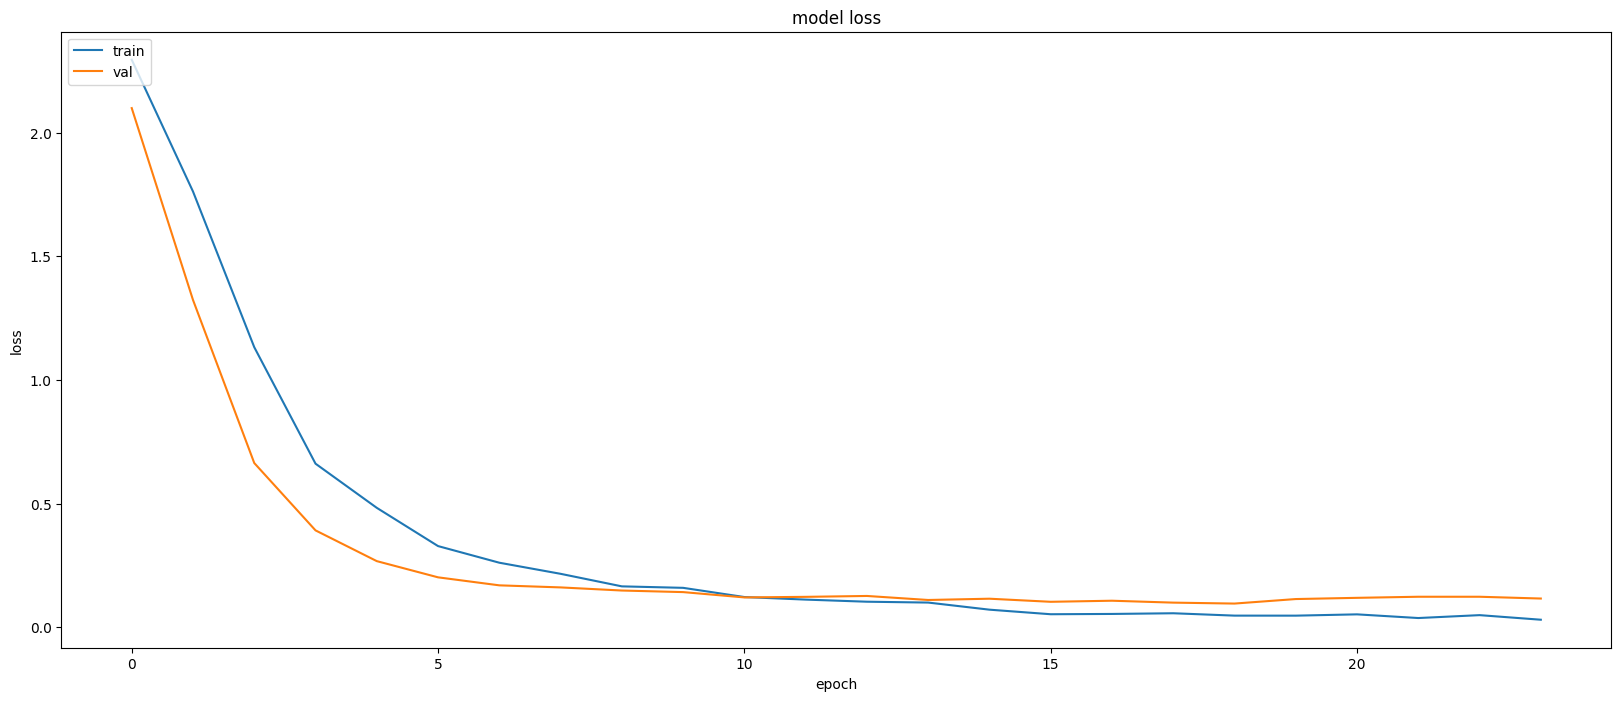

In [12]:
def plot_loss(hist):
  plt.figure(figsize=(20,8))
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
plot_loss(history)

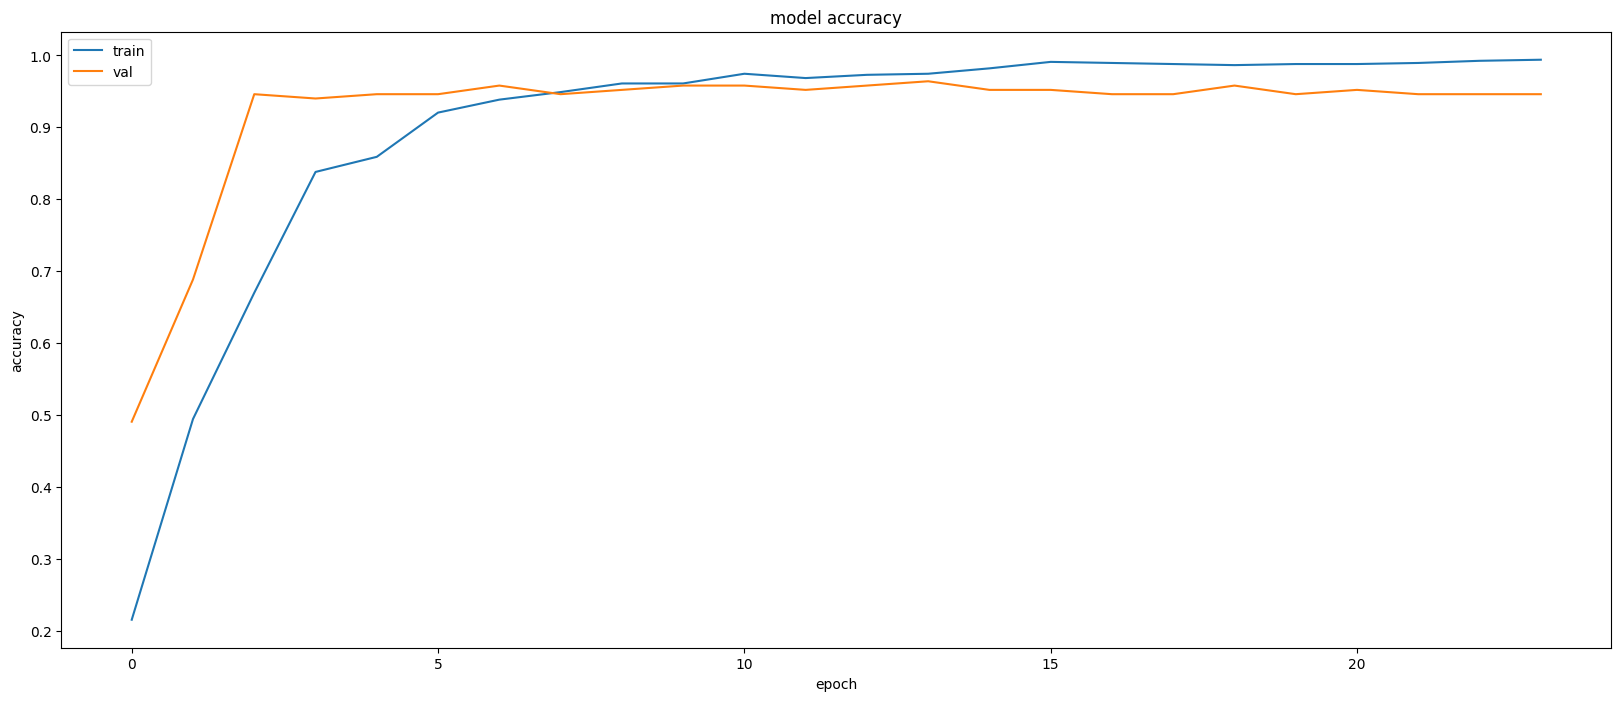

In [13]:
def plot_accuracy(hist):
  plt.figure(figsize=(20,8))
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
plot_accuracy(history)

### **Observations:**
- From the training epoch results:
  - A bigger and improved dataset appears to significantly increase the model's performance. In earlier runs, I had a smaller dataset with more intents but less patterns per intent. The model was performing relatively poorly with this dataset, and there were large fluctuations in the accuracy metric; it was all very noisy. I also didn't have enough data to confidently do a validation split. These fluctuations seem to have been reduced, implying that the model is learning the patterns in the data more effectively, with both charts being very smooth/not noisy. Having a validation split is also a very good first approach to know if the fit of the model is correct.
  - It seems that having less intents/classes but more examples/patterns per class helps the model learn a lot better and diferentiate between intents more easily.
  - The final epoch isn't the one with the highest validation accuracy, which is okay. We are using a combination of loss and accuracy for early stopping and it seems to be doing a good job. We are also saving the best model based on validation loss, that way we get the possible fit.
  - The validation split has proven beneficial in training and early stopping, as predicted in the previous observations. It also provides a way to evaluate how well the model generalizes to unseen data.
  - This simple Feed Forward Neural Network model is performing remarkably well on the dataset with an almost perfect accuracy. It's not noisy at all and it seems to learn very effectively (specially since we implemented the larger dataset). Despite not being able to capture sequence/long and short term dependencies, the model manages to achieve a very high validation accuracy. This proves that if your problem is small enough, simpler models can be a very good and cheap option and that using the newest/more complex architecture isn't always the best option.
  - The early stopping strategy based on the validation loss works well. The learning rate adjustment also appears to be effective as the model continues to improve without large fluctuations in accuracy.
  
- From the charts:
  - The smoothness of both charts indicate that the model's learning process is much more stable with this large dataset and simple architecture. This could be due to a number of factors, including a larger dataset, a refined learning rate, or possibly improved regularization techniques.
  - The model does not seem to suffer from underfitting or overfitting, as indicated by the relatively small gap between training and validation accuracy. This indicates that the model has a good bias/variance tradeoff and that it can possibly perform well in real-life use cases. We still need to test it but it's promising and could have high business impacy.
  
- In conclusion, the larger dataset and validation split have drastically improved the performance and fit of the model. This simple Feed Forward Neural Network first approach to the data treatment and model building now provides promising results and might have very high business impact while being a cheap model, however it will still be beneficial to test the model in real life use cases to confirm its effectiveness (this will be done down below). Nonetheless, further improvements can be explored by refining the text embedding process and using more sophisticated models (such as LSTMs/RNNs) or techniques like transfer learning.

## **5. Preprocessing of User Text**

The following functions will clean and preprocess the user-provided text, before feeding it into the Text Classification pipeline.

In [14]:
def clean_up_sentence(sentence):
  sentence_words = nltk.word_tokenize(sentence)
  sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
  return sentence_words

The **clean_up_sentence()** function cleans up a sentence by tokenizing it into a list of words and then lemmatizing and lowercasing each word.

In [15]:
def bag_of_words(sentence, words):
  sentence_words = clean_up_sentence(sentence)
  bag = [0] * len(words)
  for s in sentence_words:
    for i, word in enumerate(words):
       if word == s:
          bag[i] = 1
  return np.array(bag)

def predict_class(sentence):
    p = bag_of_words(sentence, words)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.1
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]

    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
      return_list.append({'intent': classes[r[0]], 'probability': str(r[1])})
    return return_list

**bag_of_words(sentence, words)** - This function takes a sentence and a list of words as input, and returns a Bag-of-Words vector for the sentence. It first uses the *clean_up_sentence()* function to tokenize and clean up the sentence, and then creates a vector of zeros with the same length as the words list. For each word in the cleaned-up sentence, it checks if the word is in the words list, and if so, sets the corresponding element in the bag-of-words vector to 1. The function then returns *the Bag-of-Words vector as a Numpy array*.

**predict_class(sentence)** - This function takes a sentence as input, and returns a list of predicted intents and their probabilities. It first creates a Bag-of-Words vector for the sentence using the *bag_of_words()* function. It then uses the trained Neural Network model (model) to predict the output probabilities for each class. *The ERROR_THRESHOLD variable is used to filter out low-probability classes*, and the remaining classes are sorted in descending order of probability. The function then creates a list of dictionaries, where each dictionary contains the predicted intent and its probability. The list is sorted in descending order of probability, and then returned.

In [16]:
def get_response(intents_list, intents_json):
    try:
        tag = intents_list[0]['intent']
        list_of_intents = intents_json['intents']
        for i in list_of_intents:
            if i['tag']  == tag:
               result = random.choice(i['responses'])
               break
    except IndexError:
        result = "I don't understand!"
    return result

This function allows you to retrieve a response for a predicted intent by looking up the corresponding intent in the intents_pizza.json file and randomly choosing a response from the responses list. If no intent was predicted, a default response is returned.

## **6. Testing our Chatbot**

After getting the response from the chatbot, get that response read by a Text-to-Speech (TTS) model of your choice, to create the Voicebot.

Modern Text-to-Speech models use Deep Learning techniques to generate synthetic speech from text. The process involves three main steps: text processing, acoustic modeling, and waveform synthesis. In this notebook, we will be utilizing a function that abstracts out these steps and directly converts our text into machine speech.

## **7. Importing the Necessary Libraries for Text-to-Speech (TTS)**

In [17]:
# Import necessary libraries here
# Import any Text to Speech model - for example, Google Text-to-Speech (gTTS)
from gtts import gTTS
# Import Audio method from IPython's Display Class
from IPython.display import Audio
import time

## **8. Implementing the TTS (20 marks)**

In [18]:
def text_to_speech(txt, filename="output.wav"):
  tts = gTTS(res)
  tts.save(filename)
  return filename
message = input("")
ints = predict_class(message)
res = get_response(ints, intents)
print(res)
filename=text_to_speech(res)
Audio(filename,  rate = 44100)


Do you have vegan options or no?
1/1 [==============================] - 0s 90ms/step
Yes, we do have vegan options available. We offer a variety of vegan toppings and we can also make a pizza with vegan cheese on request.


## **9. Creating a Sequential Deep Learning Model with RNNs/LSTMs/GRUs**

The provided code was not working properly, model had horrible accuracy specially when tested. Turns out x_train in here was being made from unshuffled documents, but y_train wasnt being changed and we were using the old shuffled y_train, so the relationship between x and y was lost. Adapted code to keep this relationship.

In [19]:
word_to_index = {'<PAD>': 0, '<UNK>': 1}
for i, word in enumerate(words):
    word_to_index[word] = i + 2

In [20]:
tokenized_sentences = []
for document in documents:
    tokens = []
    for word in document[0]:
        if word in word_to_index:
            tokens.append(word_to_index[word])
        else:
            tokens.append(word_to_index['<UNK>'])
    tokenized_sentences.append(tokens)
from tensorflow.keras.preprocessing.sequence import pad_sequences
training2=[]
max_len = 10
padded_sentences = pad_sequences(tokenized_sentences, maxlen=max_len, padding='post', truncating='post')
for index,sentence in enumerate(padded_sentences):
  training2.append([sentence,unshuffled_y[index]])
random.shuffle(training2)
training2 = np.array(training2)
train_x_lstm = np.array(list(training2[:, 0]))
train_y_lstm = np.array(list(training2[:, 1]))

print(train_x_lstm.shape)

(834, 10)


<ipython-input-20-1a55249fcdaf>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training2 = np.array(training2)


### **9.1 Creating the Complex Architecture with Embedding layer, RNN/LSTM/GRU, and compiling your model**
### **(10 marks)**

In [21]:

vocab_size = len(word_to_index)
reg_lambda = 0.001
model2 = Sequential()
model2.add(Embedding(vocab_size, 128, input_length=max_len))
model2.add(Dropout(0.5))
model2.add(Bidirectional(LSTM(128,dropout=0.2,recurrent_dropout=0.2)))
model2.add(Dropout(0.5))
model2.add(Dense(64))
model2.add(Dropout(0.5))
model2.add(Dense(len(train_y_lstm[0]), activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 128)           76160     
                                                                 
 dropout_2 (Dropout)         (None, 10, 128)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

### **9.2 Training your model (15 marks)**

In [22]:
model_name = "model2LSTM.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 10, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

history2 = model2.fit(train_x_lstm,train_y_lstm,
                      validation_split=0.2,
                    epochs=100, callbacks=[earlystopping, checkpoint, learning_rate_reduction])

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 2.3408 - accuracy: 0.1394
Epoch 1: val_loss improved from inf to 2.23355, saving model to model2LSTM.h5
21/21 [==============================] - 10s 107ms/step - loss: 2.3408 - accuracy: 0.1394 - val_loss: 2.2335 - val_accuracy: 0.2156 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 2.1070 - accuracy: 0.2129
Epoch 2: val_loss improved from 2.23355 to 1.86309, saving model to model2LSTM.h5
21/21 [==============================] - 2s 76ms/step - loss: 2.1070 - accuracy: 0.2129 - val_loss: 1.8631 - val_accuracy: 0.3054 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 1.8241 - accuracy: 0.2969
Epoch 3: val_loss improved from 1.86309 to 1.47292, saving model to model2LSTM.h5
21/21 [==============================] - 2s 87ms/step - loss: 1.8241 - accuracy: 0.2969 - val_loss: 1.4729 - val_accuracy: 0.4132 - lr: 0.0010
Epoch 4/100
21/21 [=======================

In [23]:
#Load best model
# Load the saved model
model2 = load_model('model2LSTM.h5')


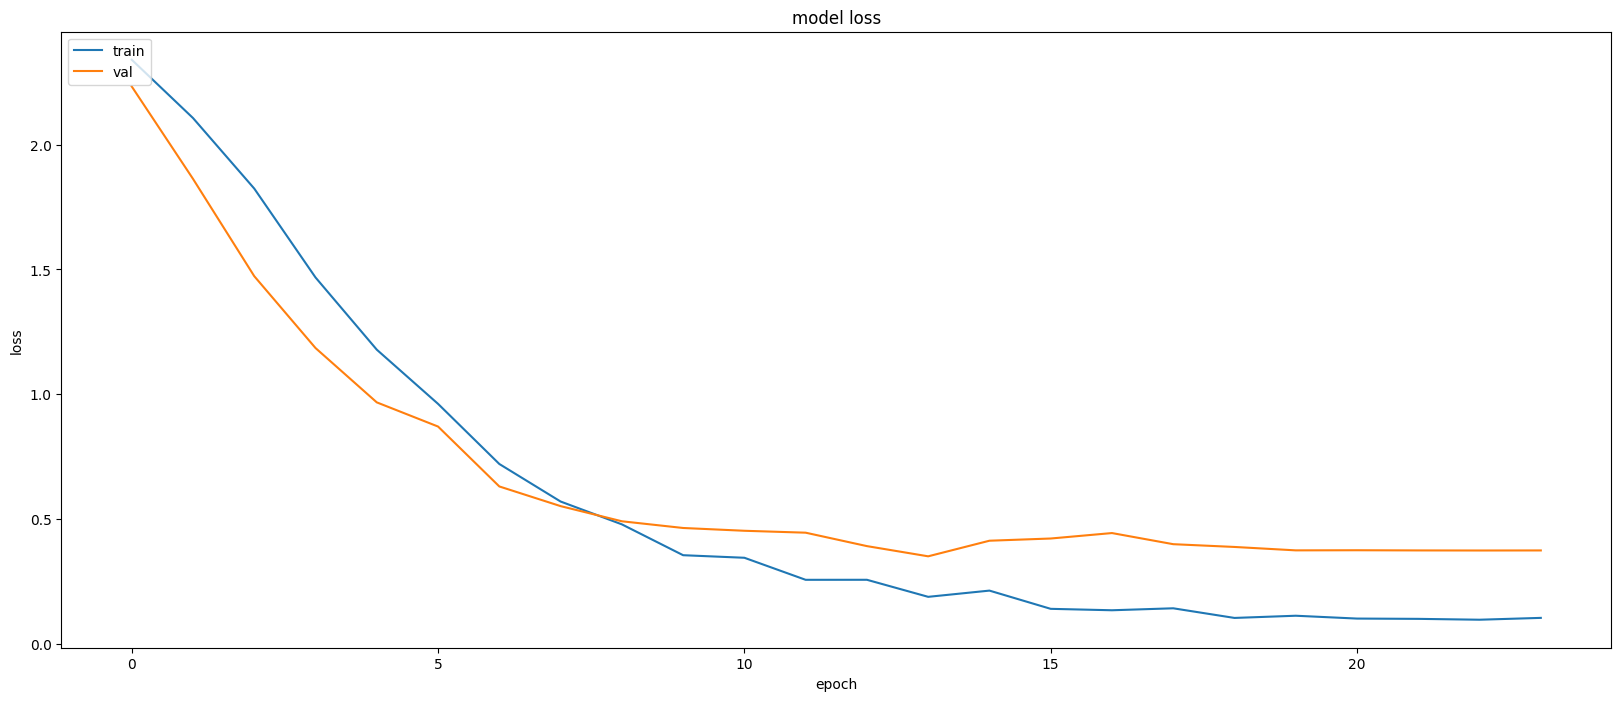

In [24]:
plot_loss(history2)

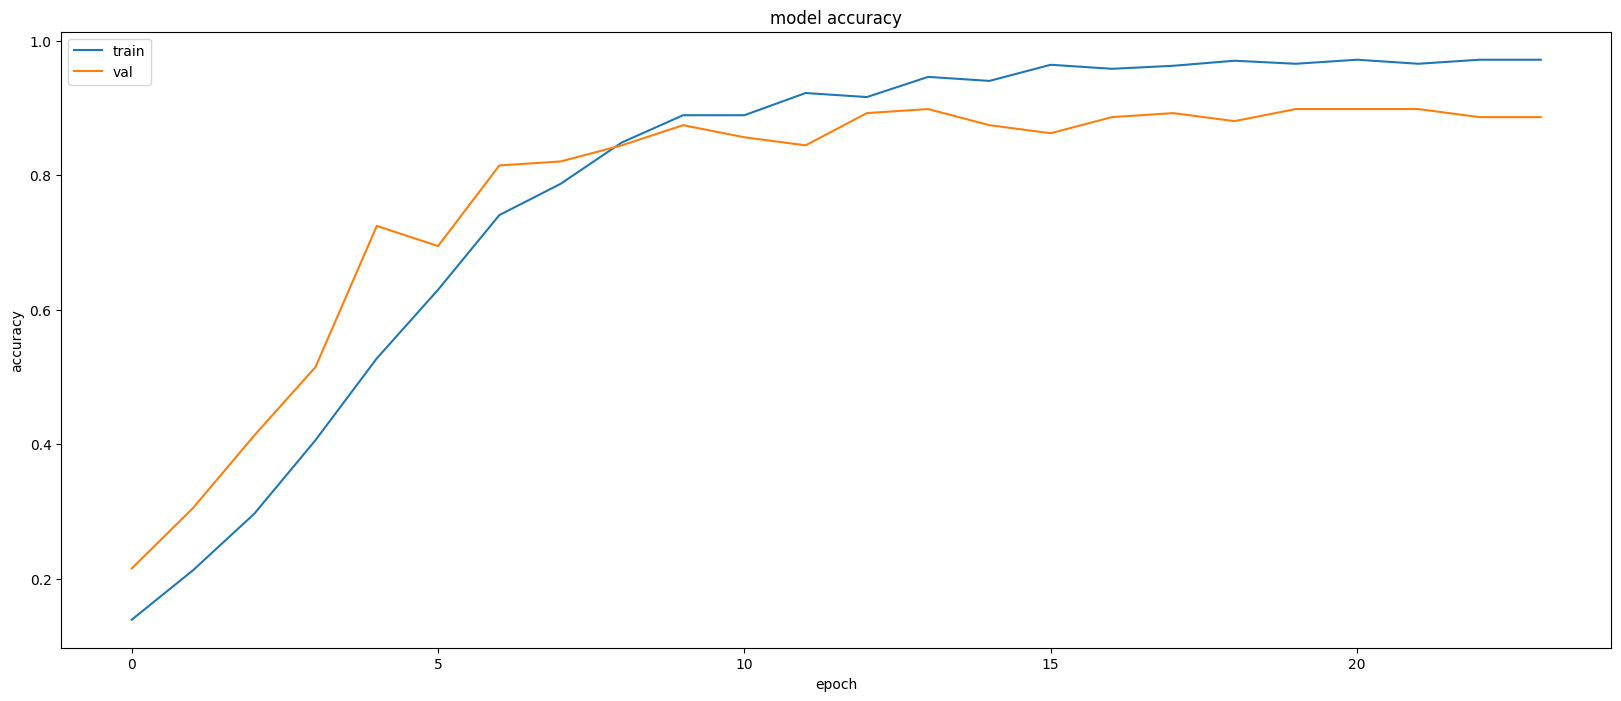

In [25]:
plot_accuracy(history2)

Model seems to be overfitting very slightly. Our 800 patterns might not be enough for an RNN or LSTM. Extremely high training accuracy, validation is amazing too but not as high as simpler ANN model.

### **Observations:**
The LSTM model also displays a robust performance, but there are certain features to take note of:


1. **Learning Rate and Performance Correlation:** The model seems to have a steady decrease in loss and increase in accuracy as the learning rate reduces. Our reduce learning rate on plateau callback seems to be working

2. **Val_loss vs Loss:** The trend of validation loss and training loss seem to indicate overfitting might be starting. Initially, both training loss and validation loss decrease at roughly the same pace, which is a good sign. However, as the epochs increase, the validation loss does not improve much (sometimes even worsening) while the training loss keeps decreasing. This could be a sign of overfitting, where the model performs well on the training data, but might not generalize well on unseen data. This is also evident on the chart, the val_loss is a lot noisier than the loss. A proper fit is one of the most important things to have on a chatbot NLU model.

3. **Val_accuracy vs Accuracy:** The training accuracy keeps improving most of the time (over 95%), but the validation accuracy plateaus a lot sooner. This could be another sign of overfitting, as the model continues to improve on the training data but does not show equivalent improvement on the validation data. This is also evident by the noise present on the accuracy chart's val_accuracy metric.

4. **Early Stopping:** The early stopping mechanism kicks in because validation loss stops improving for long enough, this is good as it can help combat overfitting.

5. **Learning Rate Decay:** The learning rate decay kicks in when progress plateaus, which does happen during training. This reduction in learning rate sees to be beneficial in stopping plateaus when the model is getting close to perfect accuracy.
6. **Final thoughts on model** In conclusion, this LSTM model demonstrates very good performance (roughly 90%+ in both training and validation, which can easily mean a lot of real world value added), but shows signs of overfitting. While an LSTM model is usually better than a simple Feed Forward Network in larger corpus because of it's capacity of understanding sequence dependencies, this dataset is small and such a complex model might be overkill. It continues to improve on the training data but struggles to make similar improvements on the validation data. This model could potentially benefit from additional techniques to mitigate overfitting, but we are already using dropouts. Perhaps adding L2 regularization could help. The use of early stopping and learning rate decay helps in preventing the model from overfitting. The model was also significantly slower (and will be more expensive if used in production) because of the sequential nature and added complexity of LSTMs vs simple Feed Forward Networks. Perhaps an RNN would've been a better approach, or looking into increasing the corpus size even more.

## **10. Testing Model2 on our chatbot**

In [26]:
def predict_class(sentence):
    tokenized_sentence = []
    tokens = []
    for word in sentence.split():
        if word in word_to_index:
            tokens.append(word_to_index[word])
        else:
            tokens.append(word_to_index['<UNK>'])
    tokenized_sentence.append(tokens)
    padded_sentence = pad_sequences(tokenized_sentence, maxlen=max_len, padding='post', truncating='post')
    res = model2.predict(padded_sentence)[0]
    ERROR_THRESHOLD = 0.1
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]

    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
      return_list.append({'intent': classes[r[0]], 'probability': str(r[1])})
    return return_list

In [27]:
def get_response(intents_list, intents_json):
    try:
        tag = intents_list[0]['intent']
        list_of_intents = intents_json['intents']
        for i in list_of_intents:
            if i['tag']  == tag:
               result = random.choice(i['responses'])
               break
            else:
              response= "Im sorry, I cannot understand your query."
    except IndexError:
        result = "I don't understand!"
    return result

In [29]:
message = input("")
ints = predict_class(message)
res = get_response(ints, intents)
print(res)
filename=text_to_speech(res)
Audio(filename,  rate = 44100)


What pizzas do you have on your menu?
1/1 [==============================] - 0s 33ms/step
Our menu includes a variety of pizzas with a wide range of toppings. We have both traditional favorites like Margherita and Pepperoni, as well as unique offerings like BBQ Chicken and Veggie Supreme. We also offer options for vegan and gluten-free pizzas. All pizzas are available at small, medium and large sizes. For more details, you can check out our menu on our website.


##**Bonus: BERT**##

In [38]:


# Load BERT model and tokenizer
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# BERT needs sentences not tokens. So let's prepare data for BERT
sentences = [' '.join(document[0]) for document in documents]
training_bert=[]
for index, sentence in enumerate(sentences):
  training_bert.append([sentence,unshuffled_y[index]])
random.shuffle(training_bert)
training_bert = np.array(training_bert)
x_bert = list(training_bert[:, 0])
y_bert = np.array(list(training_bert[:, 1]))
#Model building
def create_bert_model():
    # BERT inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # BERT model
    bert_output = bert_model([input_ids, token_type_ids, attention_mask])[1]

    # Classifier model
    dropout = Dropout(0.3, name="dropout")(bert_output)
    output = Dense(units=len(classes), activation="softmax", name="output")(dropout)

    return Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=output, name="BERT_finetuned")

# Initialize BERT fine-tuned model
model_bert_finetuned = create_bert_model()

# Compile the model
optimizer = Adam(learning_rate=5e-5)
loss = CategoricalCrossentropy()
metric = CategoricalAccuracy("accuracy")

model_bert_finetuned.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[metric])

# Prepare inputs
inputs = bert_tokenizer(x_bert, padding=True, truncation=True, max_length=max_len, return_tensors="tf")

# Train the model
history = model_bert_finetuned.fit(x=[inputs["input_ids"], inputs["token_type_ids"], inputs["attention_mask"]], y=y_bert, epochs=5, validation_split=0.2)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5
21/21 [==============================] - 163s 6s/step - loss: 1.9928 - accuracy: 0.3118 - val_loss: 1.3634 - val_accuracy: 0.6108
Epoch 2/5
21/21 [==============================] - 118s 6s/step - loss: 0.8378 - accuracy: 0.7601 - val_loss: 0.5000 - val_accuracy: 0.8862
Epoch 3/5
21/21 [==============================] - 117s 6s/step - loss: 0.2662 - accuracy: 0.9415 - val_loss: 0.2078 - val_accuracy: 0.9401
Epoch 4/5
21/21 [==============================] - 113s 5s/step - loss: 0.0843 - accuracy: 0.9910 - val_loss: 0.1201 - val_accuracy: 0.9521
Epoch 5/5
21/21 [==============================] - 123s 6s/step - loss: 0.0327 - accuracy: 0.9970 - val_loss: 0.1293 - val_accuracy: 0.9581


BERT also performed amazingly when fine-tuned on our small corpus. LLMs have the bonus of being pretrained on a gigantic amount of data and thus giving them a very strong understanding of semantics.

## **11. Observations and Conclusions (5 marks)**

This project was a very insightful experience in designing and implementing a natural language understanding (NLU) model for a chatbot for a pizzeria business. There were significant insights extracted from developing this project:

1. **Model Design and Tokenization Techniques:** It was possible to see the differences between a simpler Bag-of-Words (BoW) tokenization with an Artificial Neural Network (ANN) and a more complex tokenization techniques combined with embeddings and LSTM models. Despite first thoughts possibly being that the most complex models would be better, it was learned that this depends on the use case and the size/contents of the corpus. The choice of model and tokenization technique, as well as its success can vary greatly. This project is a testament to this, as the ANN model, despite its simplicity, outperformed the LSTM model in some critical ways and could be more impactful in real world use cases for the chatbot.

2. **Model Selection and Real-World Impact:** In terms of business impact, the simpler ANN model has several advantages. First, it achieved a higher validation accuracy. Second, it displayed no signs of overfitting or excessive noise in the training process. Third, it is significantly cheaper and simpler to maintain, an essential factor for real-world, production scenarios. In terms of cost-impact, it can outperform the LSTM. Meanwhile the BERT fine tuned model performed amazingly, but it's advantage in performance over the simple ANN is not large enough to justify the gigantic time and cost difference between them. In a real life scenario, cost-performance needs to be taken into account. Because of this, the ANN seems to be the most impactful model.

3. **Learning how to implement TTS models:** Moreover, we learned how to implement models like gTTS, which helped bring the chatbot to life through text-to-speech capabilities, thereby increasing its real-world usability and impact. This can help the pizzeria be more inclusive towards different-abled customers (for example, those with poor eyesight) and this can then bring in more of these customers who prefer this business over other competition.

4. **Learning the importance of the dataset:** The project development process also highlighted the importance of having a proper dataset. Originally, there was a smaller corpus with a lot more intents (over 30) but not many patterns (around 160 total). per intent. The ANN had decent accuracy (roughly 80%) but it was extremely noisy and there seemed to be an underfit. The LSTM performed very poorly, even RNNs and GRUs did. This improved dramatically by adding more patterns. Then, changing towards having less intents (11) but more patterns (over 800) dramatically improved the fit and performance of both models, and the simpler ANN training results are not noisy anymore. Now the models have more examples to learn from each intent and can learn even better. The LSTM model and more complex models would improve significantly with an even more robust dataset.

4. **Exploring Other Avenues:** The project could have explored other avenues like using a one encoder Transformer model or Transfer Learning. There was previously an attempt to use these more complex architectures, but they quickly led to overfitting, probably because of the relatively small dataset. This highlights an important lesson: complexity of the model must align with the size and complexity of the dataset for optimal results. Simple RNNs or GRU models could have been potential alternatives, and in some cases, they can perform on par with, if not better than LSTM models. Transfer learning with BERT was added as a bonus and it performed amazingly, but it wasn't that far ahead of the simple ANN model and took significantly longer. In terms of performance it might be the best option, but in terms of the cost it can have it could be overkill compared to the simpler options.

As for improvements and future work, here are some thoughts:

- **Data Augmentation and or increasing the number of intents and patterns:** Given that our dataset was relatively small, augmenting it with more examples could potentially improve the models' performance, especially validation/real world performance with unseen data. More data would also allow us to experiment with more complex models without worrying as much about overfitting.

- **Hyperparameter Tuning:** Further tuning of the model hyperparameters, including the learning rate, batch size, number of layers, number of hidden units, and dropout rate, could yield improvements.

- **Regularization:** To help combat overfitting in more complex models, we could employ techniques like L2 regularization or even more advanced regularization methods.

In conclusion, this project offered highly valuable insights into how we can build a robust NLU model for a chatbot, taking into account various factors like the size of the dataset, complexity of the model, and practical considerations like cost and maintainability. It also managed to produce a highly impactful model which seems to work in real life use cases and can bring a lot of value to the pizzeria via its functionality and TTS capabilities. While our simpler ANN model emerged as the preferable choice for this specific scenario, the project reaffirmed the notion that there's no one-size-fits-all solution in machine learning. Model selection deeply depends on each use case, the corpus, and the trade-off between accuracy and cost. Overall, this was a successful project which resulted in highly impactful models for the pizzeria and it was an extremely valuable/insightful learning experience for NLU and chatbots.


# **Additional Section: Real-world Ramifications**

While we have seen a simple example of how Intent Identification would be done in a prototypical chatbot, in actuality Intent Classification is a very active area of research involving large ensemble architectural models. The nuances of Natural Language means extracting intents from prompts with 99%+ accuracy is often quite a difficult proposition.

The **RASA Diet** architecture (used inside the NLU portion of the RASA Conversational AI framework) is one such example of this:


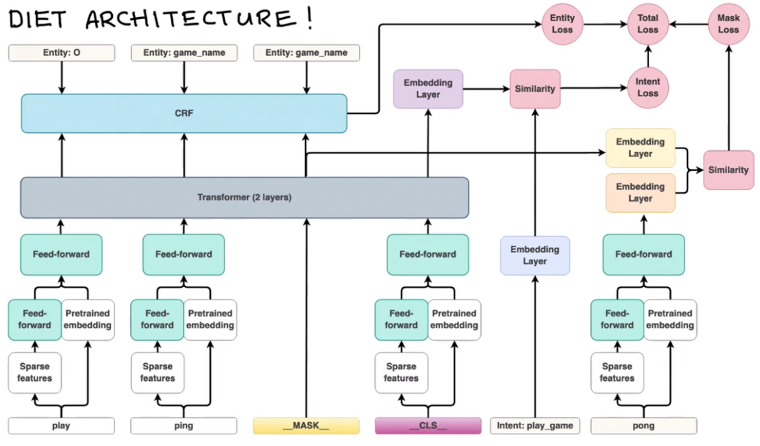

Instead of just relying on Dense Embeddings for sentences, RASA NLU tries to use Sparse / One-hot Encodings of words as part of a larger scheme of deriving the best possible embeddings for Conversational Understanding, in order to derive the intents and entities. It is a LEGO-style architecture, where one can swap out various parts of the model with other equivalent blocks.

As an example, for getting the Pretrained Embeddings, one could easily swap out Word2vec for BERT, and for the Sparse Embeddings, one could easily use TF-IDF in place of Bag-of-Words.

While such models may be too complex for all but industry-grade NLP solutions, it is worth remembering the Law of Diminishing Returns in building AI products - achieving a 10% reduction in error often requires a significant jump in complexity, and that is where the cutting-edge of the industry often functions.